In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
import os 
import re


from sklearn.model_selection import GridSearchCV


In [40]:
df_regions=pd.read_csv("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/PEPR_Marseille/Selected subjects/For each subject/Evaluation_metrics_with_v4/Quantile for each subject/List_of_regions")

In [41]:
df_regions

,Unnamed: 0,index_subject,list of regions
0,0,5,"[('S.F.median-S.F.pol.tr.-S.F.sup.', 'R'), ('S..."
1,1,6,"[('S.Call.-S.s.P.-S.intraCing.', 'L'), ('S.s.P..."
2,2,14,"[('S.T.i.-S.T.s.-S.T.pol.', 'L'), ('S.T.i.-S.O..."
3,3,16,"[('F.Coll.-S.Rh.', 'L'), ('S.T.i.-S.T.s.-S.T.p..."
4,4,17,"[('S.F.median-S.F.pol.tr.-S.F.sup.', 'R'), ('S..."
...,...,...,...
114,114,685,"[('S.Call.', 'L'), ('S.Call.-S.s.P.-S.intraCin..."
115,115,690,"[('S.Po.C.', 'L'), ('S.C.-S.Po.C.', 'L'), ('F...."
116,116,694,"[('S.T.i.-S.T.s.-S.T.pol.', 'L'), ('Lobule_par..."
117,117,699,"[('S.F.median-S.F.pol.tr.-S.F.sup.', 'R'), ('S..."


In [42]:
#Embeddings SC-SPoC_left
Embeddings = pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SPoC_left_UKB_16-39-29_183/PEPR_Marseille/Embeddings.csv")

In [43]:
Embeddings= Embeddings.iloc[:,1:75]
Embeddings= np.array(Embeddings)

In [44]:
dir_path = "/neurospin/tmp/fred/models/2025-11-10"

In [45]:
def find_subfolder_starting_with(c, c2):
    for name in os.listdir(c):
        full_path = os.path.join(c, name)
        if os.path.isdir(full_path) and name.startswith(c2):
            return full_path
    return None

In [46]:

selected_index = np.load("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/PEPR_Marseille/All the subjects/histogram_non_zero/index_to_save.npy")

In [47]:
Embeddings= Embeddings[selected_index,:]

In [48]:
X=[]
y=[]

In [49]:
import ast

In [50]:
for i in df_regions["index_subject"]:

    L=df_regions.loc[df_regions["index_subject"] == i, "list of regions"].iloc[0]
    L = ast.literal_eval(L)

    ROI=[] #Regions Of Interest

    for all_region in L:
        
        side =all_region[1]
        region= all_region[0]

        region= region.replace(".","")

        if side=='L':
            region= region + "_left"
        if side=='R':
            region= region + "_right"

        #dir_region = find_subfolder_starting_with(dir_path, region) #The path to the corresponding region

        ROI.append(region)

    if ("STi-STs-STpol_right" in ROI or "STi-STs-STpol_left" in ROI):
        X.append(Embeddings[i,:])
        y.append(1)

    else:
        X.append(Embeddings[i,:])
        y.append(0)

    # elif "SC-SPoC_right" in ROI or "SC-SPoC_left" in ROI:
    #     X.append(Embeddings[i,:])
    #     y.append(0)

Classification

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [52]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Regression logistique

In [53]:
clf = LogisticRegression(
    solver="liblinear",
    max_iter=2000,
    random_state=42
)



In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [55]:
# y = np.random.permutation(y)

In [56]:
scores = cross_val_score(
    clf,
    X,
    y,
    cv=cv,
    scoring="accuracy"
)

print("Accuracy par fold :", scores)
print("Accuracy moyenne  :", scores.mean())
print("Écart-type        :", scores.std())


Accuracy par fold : [0.66666667 0.45833333 0.5        0.58333333 0.56521739]
Accuracy moyenne  : 0.5547101449275362
Écart-type        : 0.07175742703291091


SVM

In [57]:
from sklearn.svm import SVC

In [58]:
parameters = {'C':[10**k for k in range(-7, 4)]}

In [59]:
parameters

{'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [60]:
svc = SVC(
    kernel="linear",        
    C=1.0,
    random_state=42
)
# svc = LogisticRegression(
#        solver="liblinear",
#        max_iter=2000,
#        random_state=42
#        )
clf = GridSearchCV(svc, parameters, scoring='accuracy')

In [61]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [62]:
clf.fit(X, y)

,estimator,SVC(kernel='l...ndom_state=42)
,param_grid,"{'C': [1e-07, 1e-06, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.01


In [63]:
observed_accuracy = clf.best_score_
print('Best score: ', clf.best_score_, clf.cv_results_['std_test_score'][clf.best_index_])

Best score:  0.6557971014492754 0.046186770956456374


In [64]:
permutation_results = []

for i in range(200):
    y = np.random.permutation(y)
    clf.fit(X, y)
    permutation_results.append(clf.best_score_)

In [65]:
(np.array(permutation_results) > observed_accuracy).sum()/(len(permutation_results) + 1)

np.float64(0.06467661691542288)

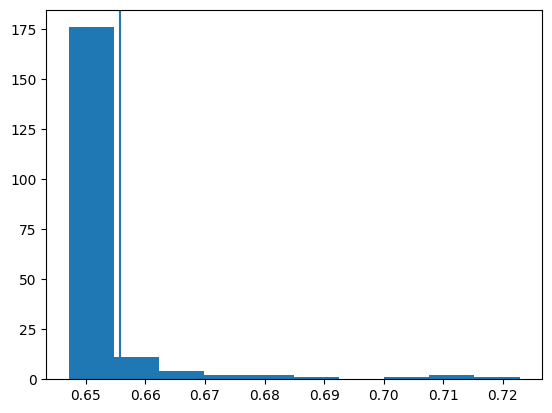

In [66]:
plt.hist(permutation_results, bins=10)
plt.axvline(observed_accuracy)
# plt.xlim(0, 1)

In [67]:
clf.cv_results_['std_test_score'][clf.best_index_]

np.float64(0.018805709090378216)

In [68]:
scores = cross_val_score(
    clf,
    X,
    y,
    cv=cv,
    scoring="accuracy"
)

print("Accuracy par fold :", scores)
print("Accuracy moyenne  :", scores.mean())
print("Écart-type        :", scores.std())


Accuracy par fold : [0.625      0.625      0.66666667 0.66666667 0.65217391]
Accuracy moyenne  : 0.6471014492753623
Écart-type        : 0.018805709090378216


In [69]:
np.array(y).sum()

np.int64(42)